In [2]:
import numpy as np
import pandas as pd
import os
from scipy import misc
import matplotlib.pyplot as plt

%matplotlib inline

pin_info_data = r'C:\Users\newline\Documents\ImageClassification\data\statistics\sam_new\aerial_cropped\prediction_stats\tr_cv_ts_pins_info.csv'

aerial_cropped_cv_stats = r'C:\Users\newline\Documents\ImageClassification\data\statistics\sam_new\aerial_cropped\prediction_stats\cvalid_pred_outcomes.csv'
aerial_cropped_ts_stats = r'C:\Users\newline\Documents\ImageClassification\data\statistics\sam_new\aerial_cropped\prediction_stats\test_pred_outcomes.csv'

aerial_cropped_image_path = r'C:\Users\newline\Documents\ImageClassification\data\input_images\sam_new\aerial_cropped'


In [62]:
import imutils
from scipy import misc

def central_crop(image, height, width):
    if image.shape[0] > height and image.shape[1] > width:
        ysize, xsize, chan = image.shape
        xoff = (xsize - height) // 2
        yoff = (ysize - width) // 2
        img = image[yoff:-yoff, xoff:-xoff]
        # print (img.shape)
    else:
        img = image
    return img


def zero_pad(inp, crop_shape, out_shape):

    m, n, c = crop_shape  
    out_m, out_n, out_c = out_shape
    
    to_pad_m = max(out_m - m, 0)
    to_pad_n = max(out_n - n, 0)
    to_pad_c = max(out_c - c, 0)
    
    pad_m1 = to_pad_m // 2
    pad_m2 = to_pad_m - pad_m1
    
    pad_n1 = to_pad_n // 2
    pad_n2 = to_pad_n - pad_n1
    
    pad_c1 = to_pad_c // 2
    pad_c2 = to_pad_c - pad_c1
    
    inp = np.pad(inp, ((pad_m1, pad_m2), (pad_n1, pad_n2), (pad_c1, pad_c2)), 'constant')
    return inp


class GetImages():
    def __init__(self, img_in_shape, img_out_shape, img_crop_shape, img_resize_shape,
                 enable_rotation=True):
        # print(img_in_shape, img_out_shape, img_crop_shape, img_resize_shape)
       
        self.img_in_shape = img_in_shape
        self.img_out_shape = img_out_shape
        
        
        if img_crop_shape is not None:
            self.img_crop_shape = img_crop_shape
        else:
            self.img_crop_shape = []
        
        if img_resize_shape is not None:
            self.img_resize_shape = img_resize_shape
        else:
            self.img_resize_shape = []
        
        if enable_rotation:
            self.angle = 90
            self.enable_rotation = enable_rotation
        else:
            self.enable_rotation = False
        
    
    def process_images_given_path(self, pic_path):
        image = misc.imread(pic_path, mode='RGB')
        
        # if self.image_type == 'aerial_cropped':
        if image.shape[0] == self.img_in_shape[0] and image.shape[1] == self.img_in_shape[1]:
            # The above condition takes care of the different sizes. If a bounding box was already cropped
            # then we don't crop further. But if no bounding box was found then we perform a central crop.
            if len(self.img_crop_shape) > 0:
                image = central_crop(image, height=self.img_crop_shape[0], width=self.img_crop_shape[1])
        
        # If the height is greater than width then we rotate the image by 90%
        if self.enable_rotation:
            if image.shape[0] > image.shape[1]:
                image = imutils.rotate_bound(image, self.angle)
        
        if len(self.img_resize_shape) > 0:
            image = misc.imresize(image, self.img_resize_shape)
        
        if image.shape[0] - self.img_out_shape[0] < 0:
            image = zero_pad(inp=image, crop_shape=self.img_crop_shape, out_shape=self.img_out_shape)
        elif len(self.img_out_shape) > 0:
            image = misc.imresize(image, self.img_out_shape)
        
        return image
    
    
def vizualize(get_img_obj, image_path_array, title_arr, data_type, rows, columns, figsize=(40, 6)):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='y', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    for no, (image_path, title) in enumerate(zip(image_path_array, title_arr)):
        image = get_img_obj.process_images_given_path(image_path)
        axs[no].imshow(np.array(image, dtype=data_type))
        axs[no].set_title(title,fontsize= 25)
        
obj_gI = GetImages(
    img_in_shape = [400, 400, 3],
    img_out_shape = [224, 224, 3],
    img_crop_shape = [128, 128, 3],
    img_resize_shape = [128, 128, 3],
    enable_rotation = True)

### Get the meta info

In [26]:
pin_info = pd.read_csv(pin_info_data, index_col=None)

print (pin_info.shape)
print (test_pins.shape)
print (cvalid_pins.shape)
pd.concat([pin_info.head(3), pin_info.tail(3)])

(11216, 3)
(1120, 3)
(1120, 3)


,property_pins,property_type,dataset_type
0,20-08-425-032-0000,land,test
1,20-20-416-019-0000,land,test
2,13-14-412-040-0000,land,test
11213,20-20-319-024-0000,house,batch_69
11214,20-32-409-015-0000,house,batch_69
11215,20-02-301-047-0000,house,batch_69


In [58]:
def get_mislabeled(checkpoint_name):
    aerial_cropped_cv = pd.read_csv(aerial_cropped_cv_stats)
    aerial_cropped_ts = pd.read_csv(aerial_cropped_ts_stats)
    print ('Aerial Cropped data: ', aerial_cropped_cv.shape, aerial_cropped_ts.shape)
    cv_ = aerial_cropped_cv[aerial_cropped_cv['checkpoint'] == checkpoint_name].reset_index()
    ts_ = aerial_cropped_ts[aerial_cropped_ts['checkpoint'] == checkpoint_name].reset_index()
    print ('Checkpoint :', cv_.shape, ts_.shape)

#     test_pins = pin_info[pin_info['dataset_type'] == 'test'].reset_index().drop('index', 1)
#     cvalid_pins = pin_info[pin_info['dataset_type'] == 'cvalid'].reset_index().drop('index', 1)
    # Column stack the data to map pins to prediction
    combined_cv_data = pd.concat([cvalid_pins[['property_pins', 'property_type']], cv_], axis=1)
    combined_ts_data = pd.concat([test_pins[['property_pins', 'property_type']], ts_], axis=1)
    print ('Column stacked data ', combined_cv_data.shape, combined_ts_data.shape)

    cv_mislabeled = combined_cv_data[(combined_cv_data['true_label'] - combined_cv_data['pred_label'] != 0) &
                                      (combined_cv_data['pred_prob'] == 1)]

    ts_mislabeled = combined_ts_data[(combined_ts_data['true_label'] - combined_ts_data['pred_label'] != 0) &
                                      (combined_ts_data['pred_prob'] == 1)]
    return (cv_mislabeled[cv_mislabeled['property_type'] == 'land'], 
            cv_mislabeled[cv_mislabeled['property_type'] == 'house'],
            ts_mislabeled[ts_mislabeled['property_type'] == 'land'],
            ts_mislabeled[ts_mislabeled['property_type'] == 'house'])


def get_pins(cv_land_mis, cv_house_mis, ts_land_mis, ts_house_mis):
    cv_land_mis_pins_path = [os.path.join(aerial_cropped_image_path, 'land', pins+'.jpg') for pins in np.array(cv_land_mis['property_pins'])]
    
    cv_house_mis_pins_path = [os.path.join(aerial_cropped_image_path, 'house', pins+'.jpg') for pins in np.array(cv_house_mis['property_pins'])]

    ts_land_mis_pins_path = [os.path.join(aerial_cropped_image_path, 'land', pins+'.jpg') for pins in np.array(ts_land_mis['property_pins'])]
    
    ts_house_mis_pins_path = [os.path.join(aerial_cropped_image_path, 'house', pins+'.jpg') for pins in np.array(ts_house_mis['property_pins'])]

    print(len(cv_land_mis_pins_path), len(cv_house_mis_pins_path), len(ts_land_mis_pins_path), len(ts_house_mis_pins_path))
    return cv_land_mis_pins_path, cv_house_mis_pins_path, ts_land_mis_pins_path, ts_house_mis_pins_path

def get_title_array(cv_land_mis, cv_house_mis, ts_land_mis, ts_house_mis):
    cv_land_mis = cv_land_mis.reset_index()
    cv_house_mis = cv_house_mis.reset_index()
    ts_land_mis = ts_land_mis.reset_index()
    ts_house_mis = ts_house_mis.reset_index()
    
    cv_land_mis['rownum'] = pd.Series(range(0,len(cv_land_mis)))
    cv_house_mis['rownum'] = pd.Series(range(0,len(cv_house_mis)))
    ts_land_mis['rownum'] = pd.Series(range(0,len(ts_land_mis)))
    ts_house_mis['rownum'] = pd.Series(range(0,len(ts_house_mis)))

    cv_land_mis_arr = np.array(cv_land_mis["rownum"].astype(str) + '--' +
                                  cv_land_mis["property_pins"].astype(str) + '--' + 
                                  cv_land_mis["pred_prob"].round(2).astype(str))

    cv_house_mis_arr = np.array(cv_house_mis["rownum"].astype(str) + '--' +
                                   cv_house_mis["property_pins"].astype(str) + '--' + 
                                   cv_house_mis["pred_prob"].round(2).astype(str))

    ts_land_mis_arr = np.array(ts_land_mis["rownum"].astype(str) + '--' +
                                  ts_land_mis["property_pins"].astype(str) + '--' + 
                                  ts_land_mis["pred_prob"].round(2).astype(str))

    ts_house_mis_arr = np.array(ts_house_mis["rownum"].astype(str) + '--' +
                                   ts_house_mis["property_pins"].astype(str) + '--' + 
                                   ts_house_mis["pred_prob"].round(2).astype(str))
    print (len(cv_land_mis_arr), len(cv_house_mis_arr), len(ts_land_mis_arr), len(ts_house_mis_arr))
    return cv_land_mis_arr, cv_house_mis_arr, ts_land_mis_arr, ts_house_mis_arr

# Analytical Answers for Questions:

### Actual Land: Predicted House, Prediction Probability = 1 

In [59]:
aerial_cropped_cv = pd.read_csv(aerial_cropped_cv_stats)
aerial_cropped_ts = pd.read_csv(aerial_cropped_ts_stats)
print (aerial_cropped_cv.shape, aerial_cropped_ts.shape)
pd.concat([aerial_cropped_cv.tail(), aerial_cropped_ts.tail()])

(10080, 5) (10080, 5)


,checkpoint,test_batch,true_label,pred_label,pred_prob
10075,epoch_17_batch_59,cvalid,1.0,1,0.972
10076,epoch_17_batch_59,cvalid,1.0,1,1.000
10077,epoch_17_batch_59,cvalid,1.0,1,1.000
10078,epoch_17_batch_59,cvalid,1.0,1,0.854
10079,epoch_17_batch_59,cvalid,1.0,1,1.000
10075,epoch_17_batch_59,test,1.0,0,0.925
10076,epoch_17_batch_59,test,1.0,1,1.000
10077,epoch_17_batch_59,test,1.0,1,1.000
10078,epoch_17_batch_59,test,1.0,0,1.000
10079,epoch_17_batch_59,test,1.0,0,0.835


In [60]:
checkpoint_name = 'epoch_17_batch_59'
cv_land_mis, cv_house_mis, ts_land_mis, ts_house_mis = get_mislabeled(checkpoint_name)
print (cv_land_mis.shape, cv_house_mis.shape, ts_land_mis.shape, ts_house_mis.shape)
pd.concat([cv_land_mis.head(2), cv_house_mis.head(2), ts_land_mis.head(2), ts_house_mis.head(2)])

Aerial Cropped data:  (10080, 5) (10080, 5)
Checkpoint : (1120, 6) (1120, 6)
Column stacked data  (1120, 8) (1120, 8)
(17, 8) (15, 8) (20, 8) (19, 8)


,property_pins,property_type,index,checkpoint,test_batch,true_label,pred_label,pred_prob
20,17-07-210-017-0000,land,8980,epoch_17_batch_59,cvalid,0.0,1,1.0
48,16-13-428-027-0000,land,9008,epoch_17_batch_59,cvalid,0.0,1,1.0
608,20-33-100-012-0000,house,9568,epoch_17_batch_59,cvalid,1.0,0,1.0
634,20-20-312-025-0000,house,9594,epoch_17_batch_59,cvalid,1.0,0,1.0
107,13-12-232-030-0000,land,9067,epoch_17_batch_59,test,0.0,1,1.0
146,16-15-206-012-0000,land,9106,epoch_17_batch_59,test,0.0,1,1.0
561,20-02-401-022-0000,house,9521,epoch_17_batch_59,test,1.0,0,1.0
605,16-09-119-014-0000,house,9565,epoch_17_batch_59,test,1.0,0,1.0


In [64]:
cv_land_mis_pins_path, cv_house_mis_pins_path, ts_land_mis_pins_path, ts_house_mis_pins_path = get_pins(cv_land_mis, cv_house_mis, ts_land_mis, ts_house_mis)
cv_land_mis_pins_title, cv_house_mis_pins_title, ts_land_mis_pins_title, ts_house_mis_pins_title = get_title_array(cv_land_mis, cv_house_mis, ts_land_mis, ts_house_mis)

17 15 20 19
17 15 20 19


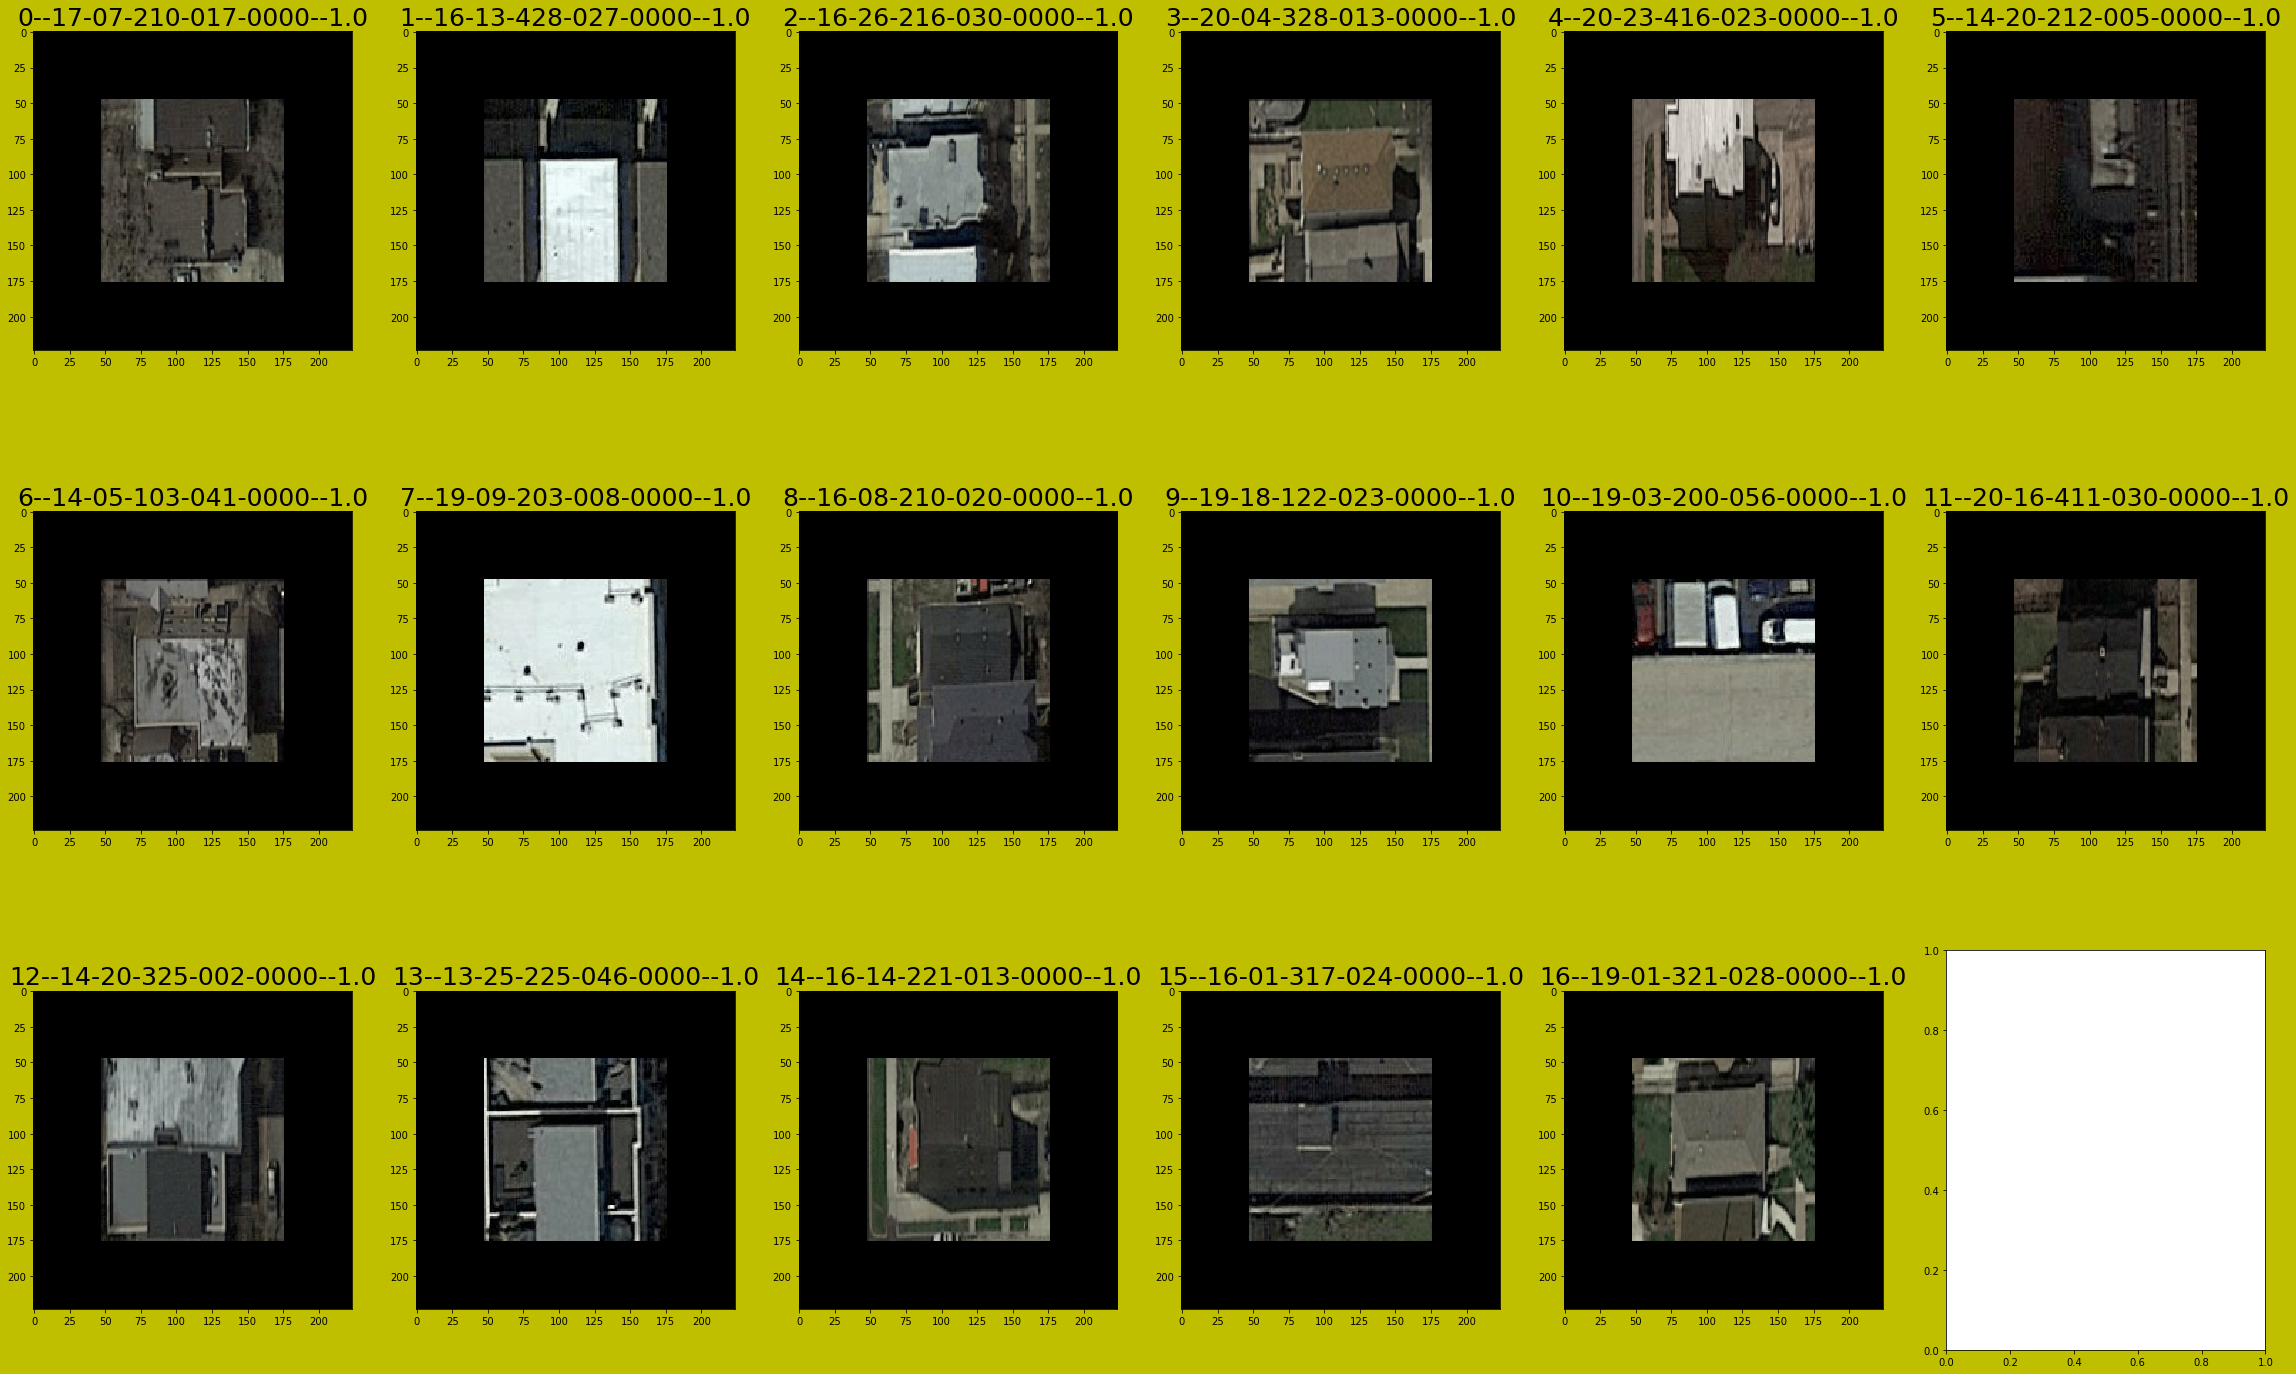

In [65]:
vizualize(obj_gI, cv_land_mis_pins_path, cv_land_mis_pins_title, data_type='uint8', rows=3, columns=6, figsize=(40, 25))

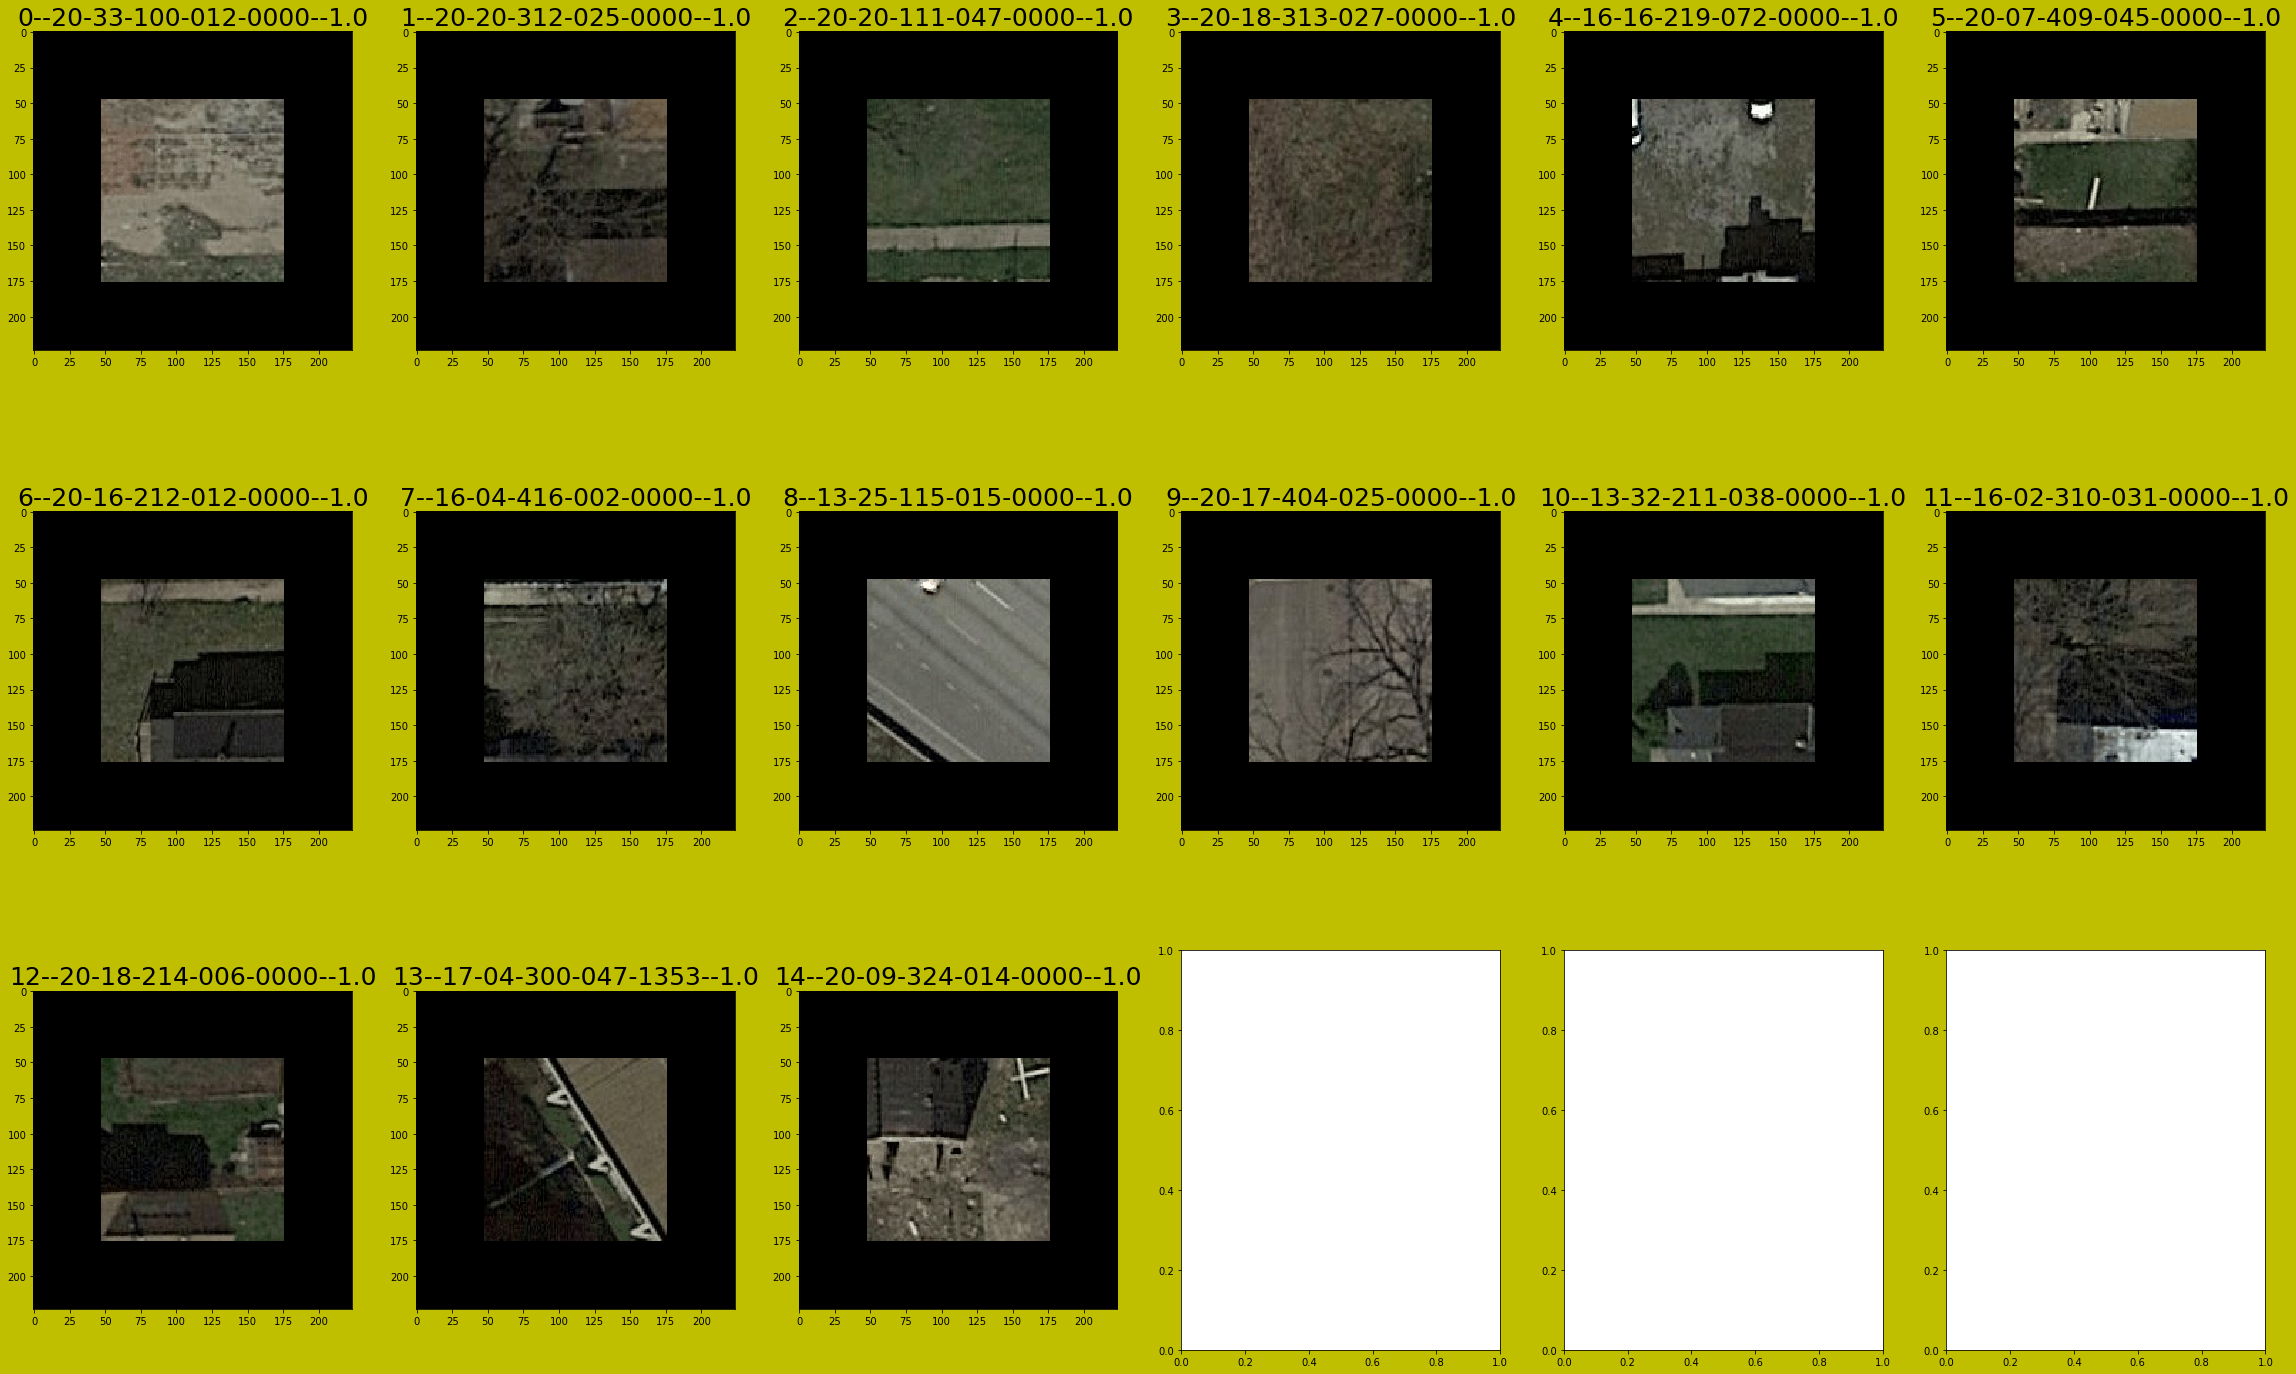

In [66]:
vizualize(obj_gI, cv_house_mis_pins_path, cv_house_mis_pins_title, data_type='uint8', rows=3, columns=6, figsize=(40, 25))

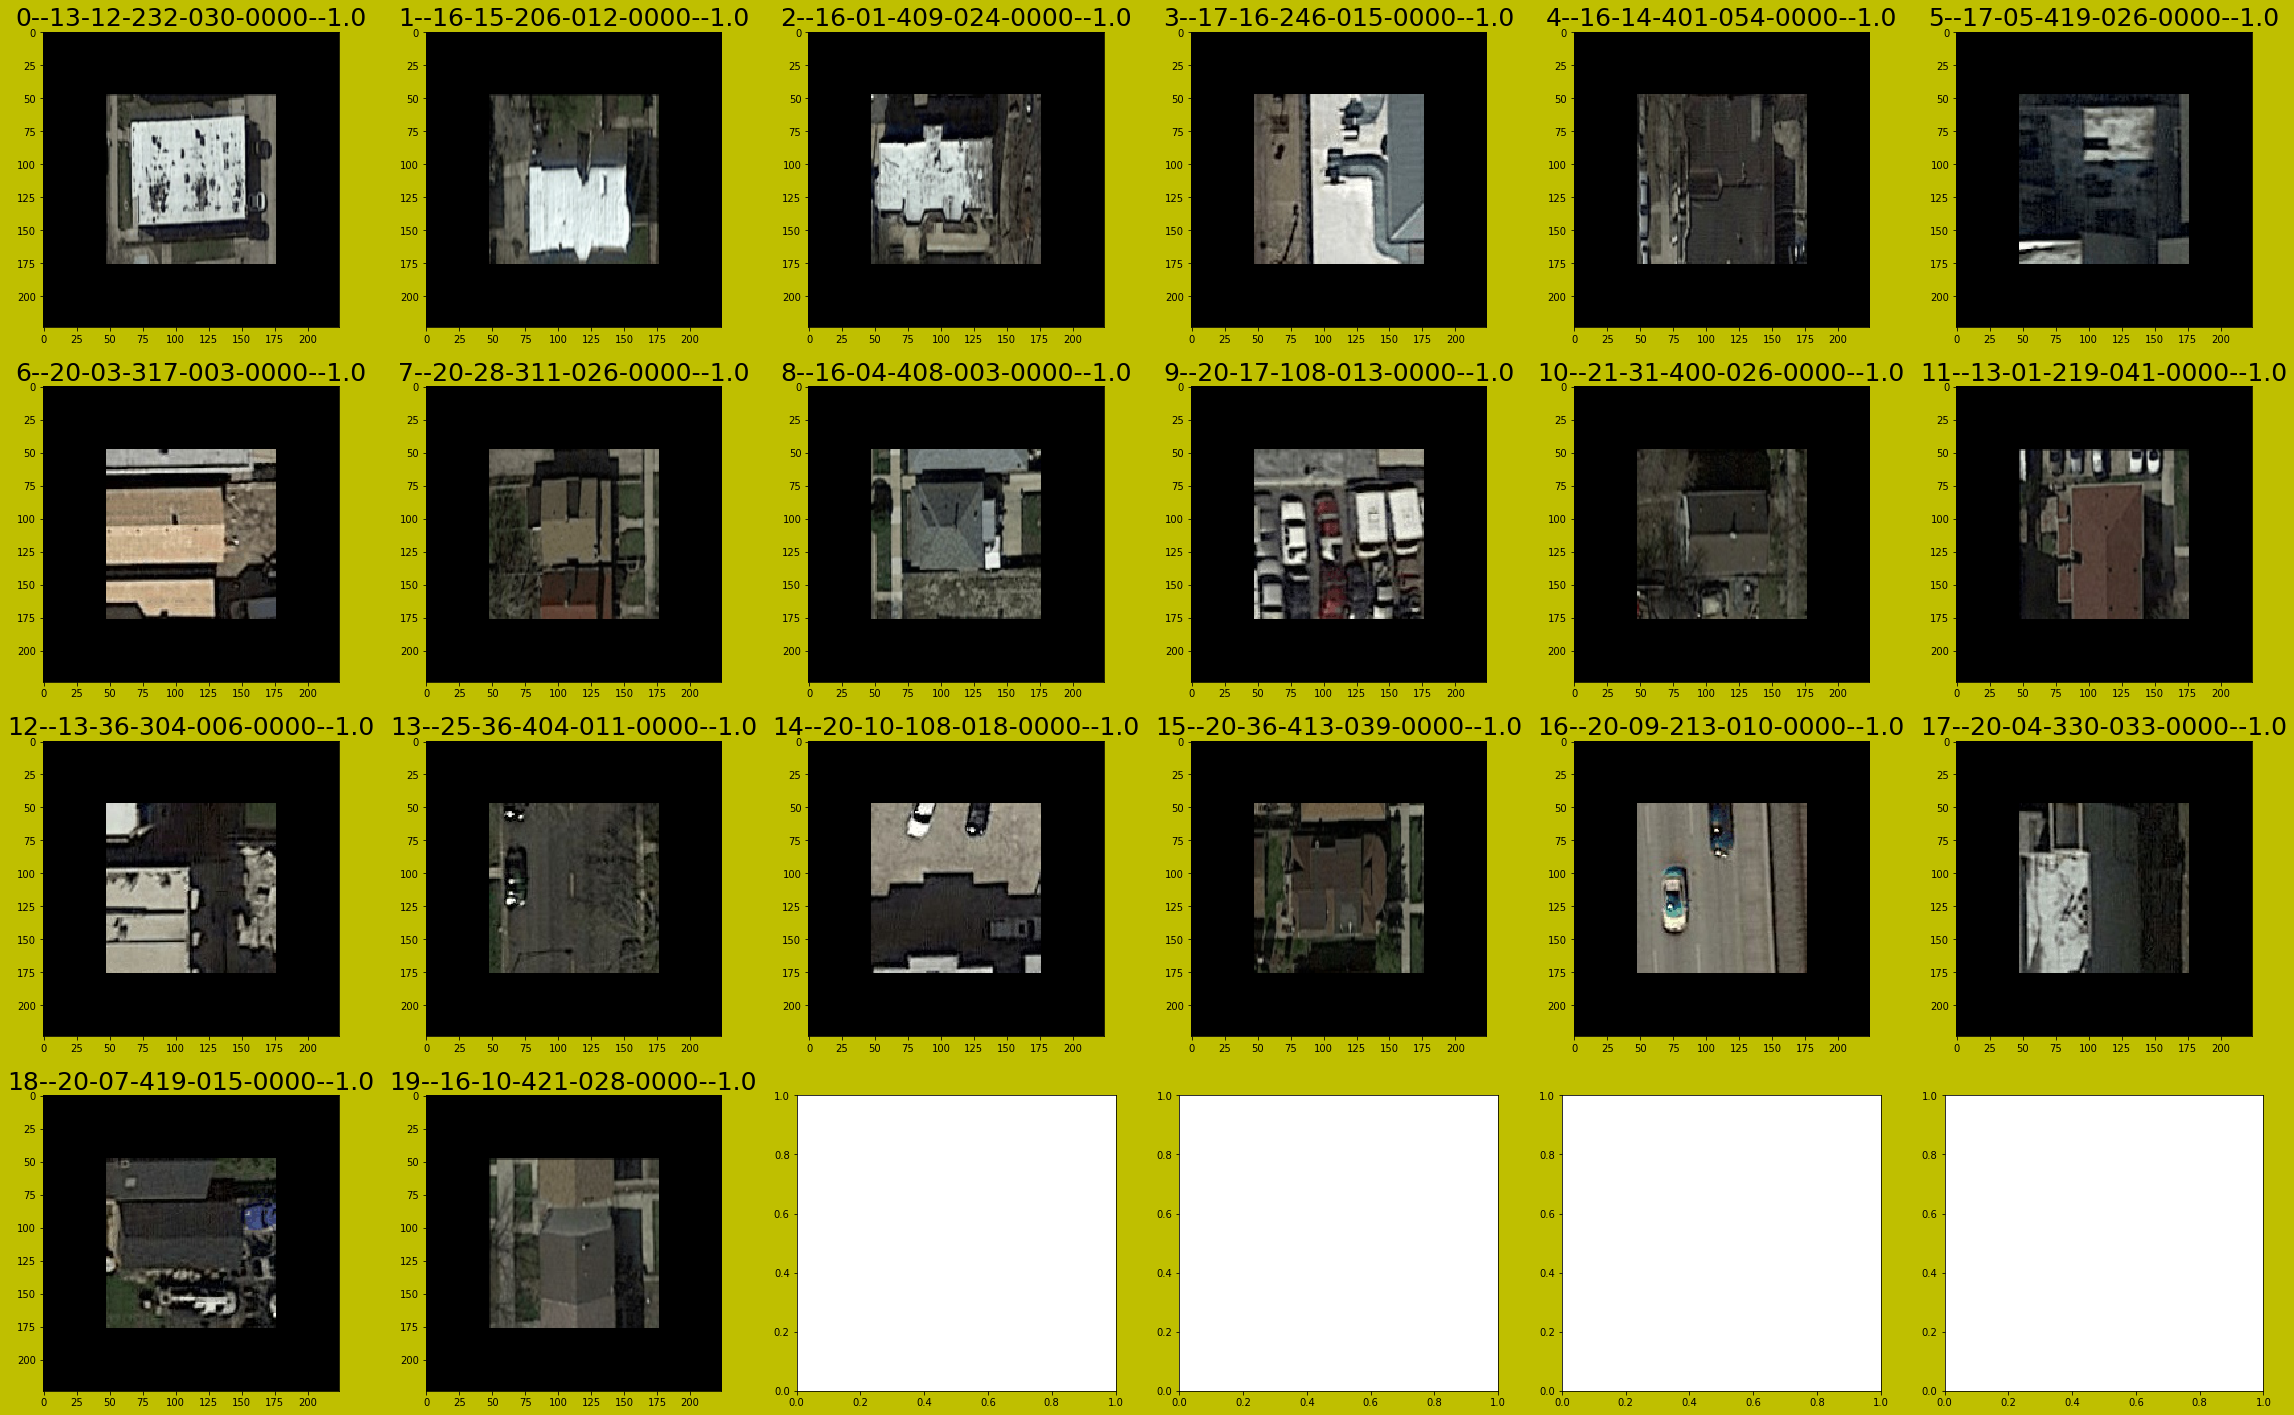

In [68]:
vizualize(obj_gI, ts_land_mis_pins_path, ts_land_mis_pins_title, data_type='uint8', rows=4, columns=6, figsize=(40, 25))

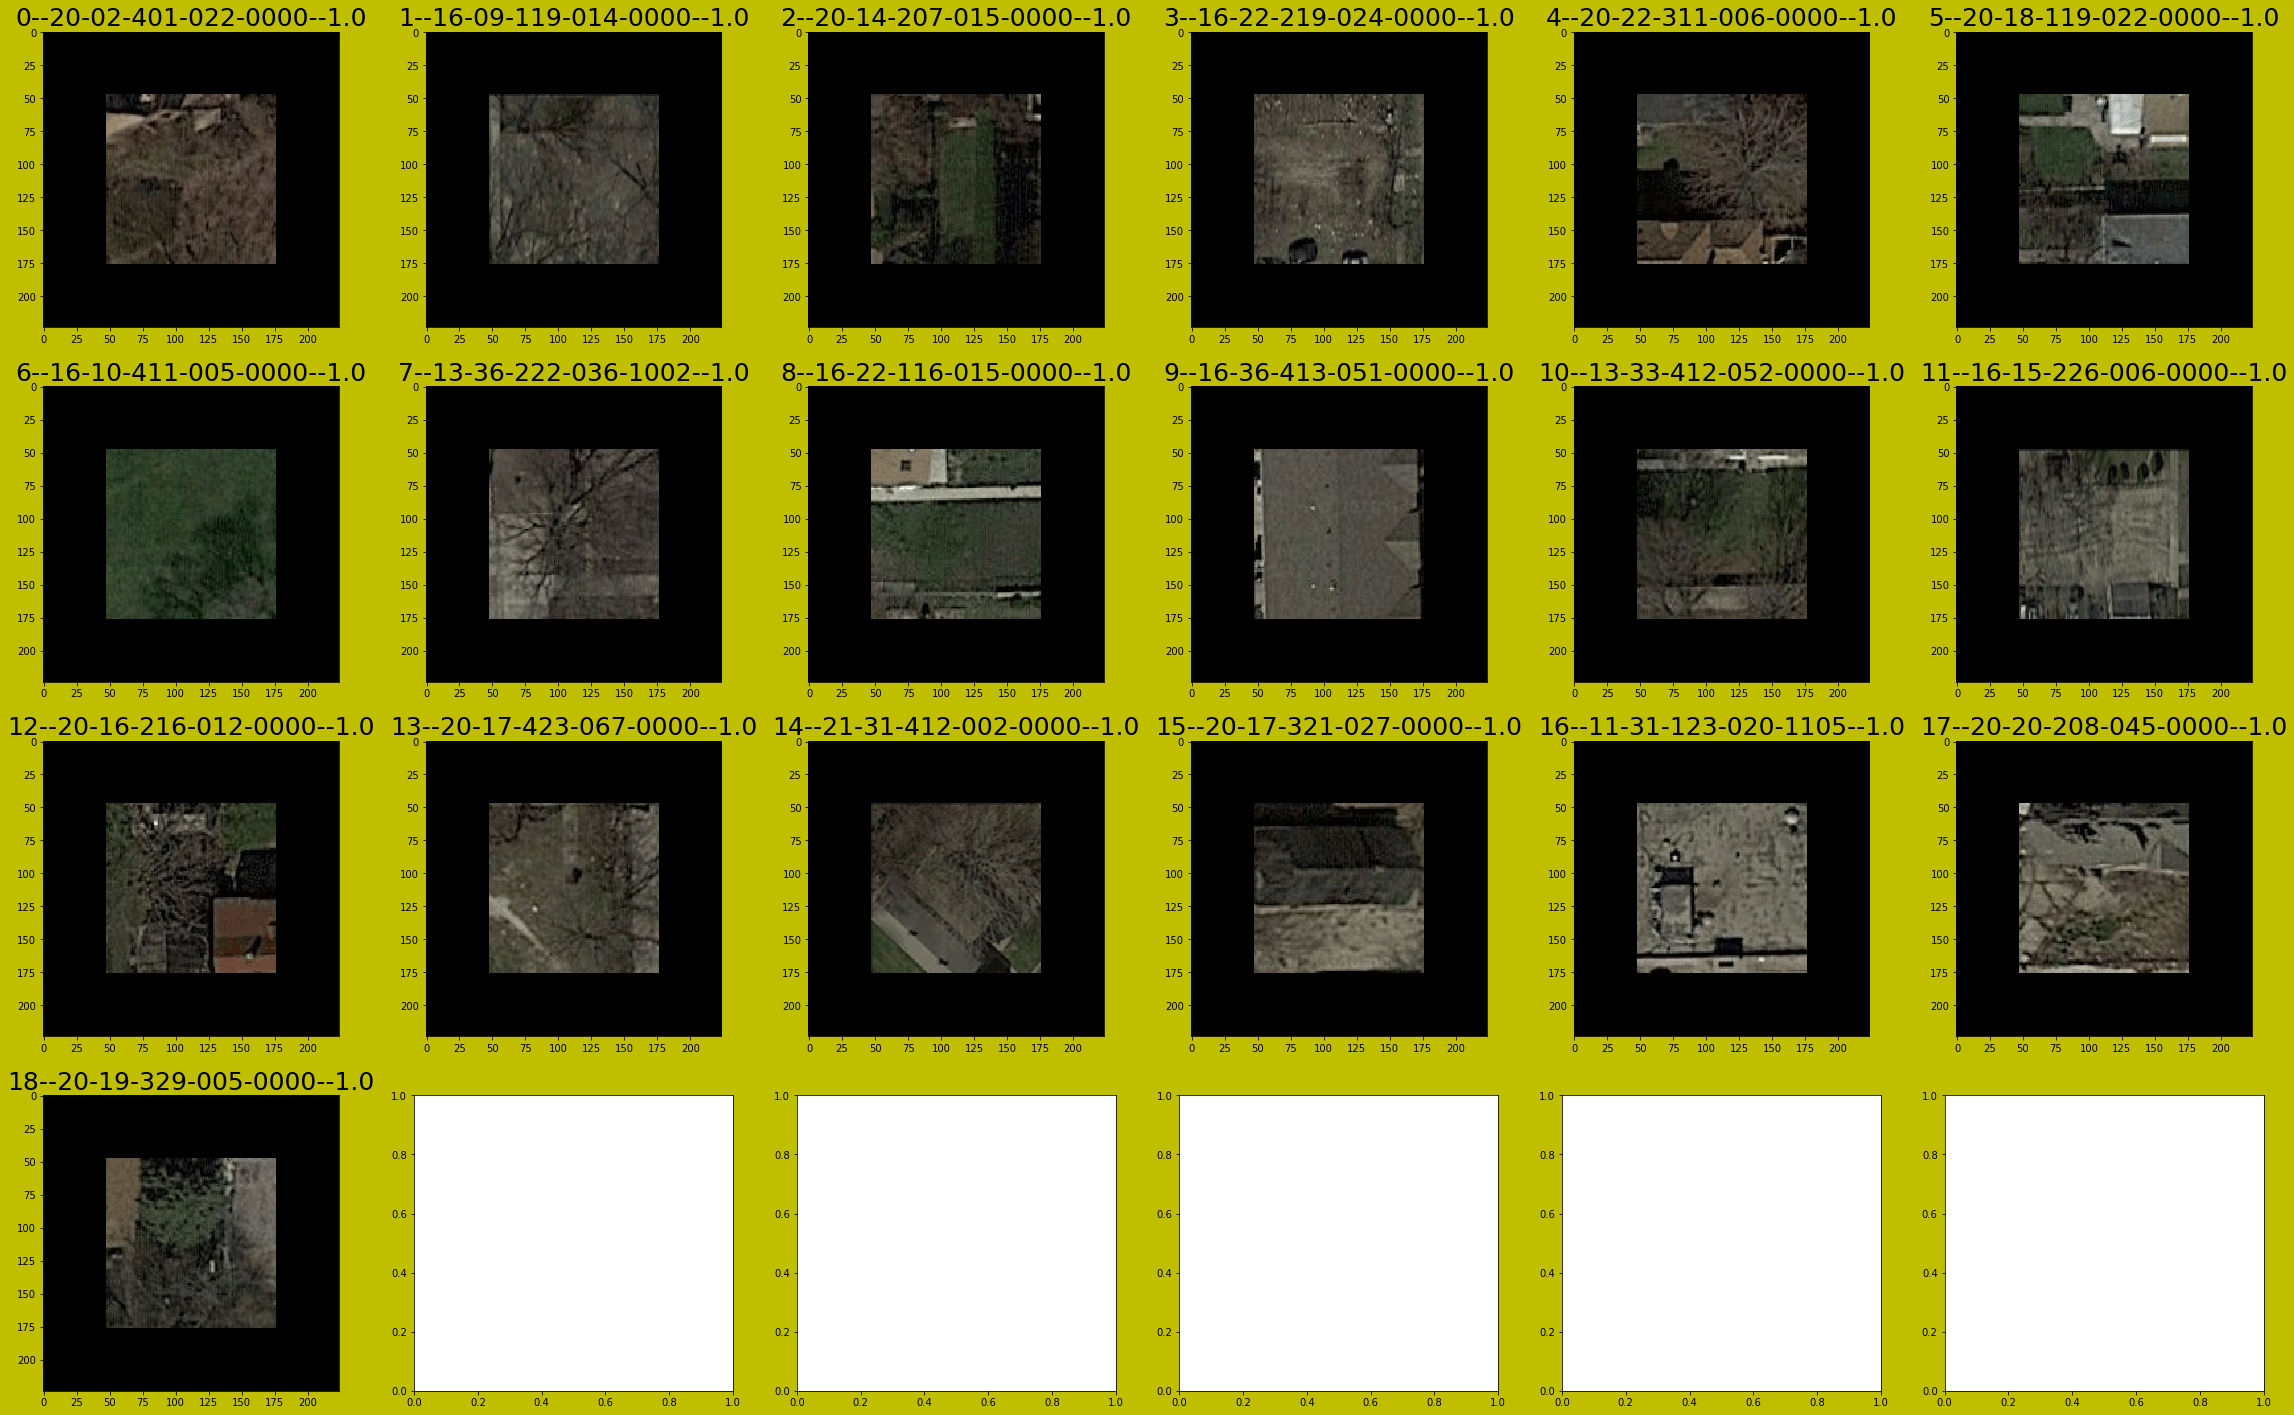

In [69]:
vizualize(obj_gI, ts_house_mis_pins_path, ts_house_mis_pins_title, data_type='uint8', rows=4, columns=6, figsize=(40, 25))